In [36]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [34]:
from sine_data import train_dataset, valid_dataset

In [35]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [75]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, time_steps):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.time_steps)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y)
        return torch.cat(ys, dim=1), h

In [80]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

In [96]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_timesteps_per_chunk=20, baseline=False):
        super().__init__()
        
        rnn = nn.GRU(1, num_hidden, batch_first=True)
        
        if baseline:
            self.rnn = rnn
        else:
            self.rnn = ClipBPTTWrapper(rnn, num_hidden, num_timesteps_per_chunk)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn(x)
        if not l0.is_contiguous():
            l0 = l0.contiguous()
        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [97]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [120]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_hidden=64,
             module__num_timesteps_per_chunk=15,
            )

In [121]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2364        0.9757  0.4188
      2        0.9845        0.7437  0.3412
      3        0.7492        0.5173  0.3910
      4        0.5205        0.3131  0.3262
      5        0.3159        0.2122  0.3365
      6        0.2187        0.3216  0.4138
      7        0.3376        0.2635  0.5279
      8        0.2758        0.1624  0.3507
      9        0.1678        0.1210  0.3704
     10        0.1222        0.1205  0.3258
     11        0.1199        0.1281  0.3290
     12        0.1272        0.1263  0.3762
     13        0.1258        0.1101  0.3325
     14        0.1103        0.0823  0.3450
     15        0.0835        0.0507  0.4107
     16        0.0534        0.0265  0.3466
     17        0.0317        0.0196  0.3259
     18        0.0284        0.0275  0.3748
     19        0.0404        0.0317  0.3260
     20        0.0469        0.0216

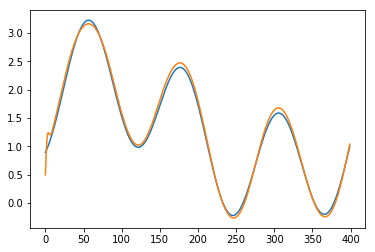

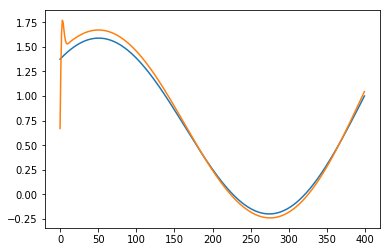

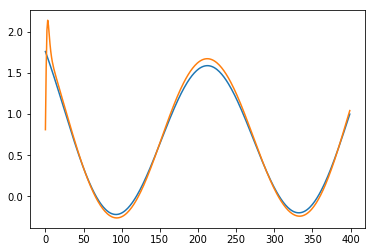

In [122]:
data = X_valid
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

## without clip (baseline)

In [99]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_base = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_hidden=64,
             module__num_timesteps_per_chunk=20,
             module__baseline=True,
            )

In [100]:
%pdb on
ef_base.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2364        0.9778  0.4214
      2        0.9866        0.7472  0.3568
      3        0.7527        0.5204  0.4128
      4        0.5238        0.3141  0.3401
      5        0.3170        0.2111  0.3390
      6        0.2180        0.3155  0.3810
      7        0.3321        0.2481  0.3482
      8        0.2603        0.1543  0.4746
      9        0.1595        0.1197  0.4359
     10        0.1209        0.1211  0.3357
     11        0.1206        0.1286  0.5007
     12        0.1278        0.1266  0.3972
     13        0.1262        0.1107  0.3323
     14        0.1110        0.0834  0.3292
     15        0.0847        0.0520  0.5117
     16        0.0548        0.0269  0.3325
     17        0.0321        0.0182  0.3368
     18        0.0271        0.0257  0.3864
     19        0.0387        0.0317  0.3347
     20        0.0472        0.0235

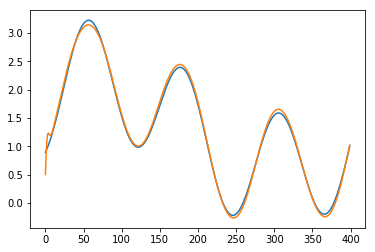

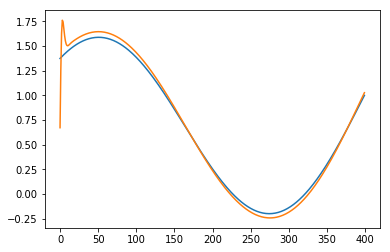

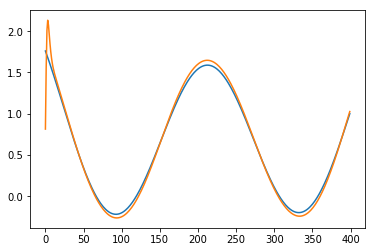

In [101]:
data = X_valid
pred = ef_base.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])